# Cepheids in the BGM simulation of Mor+2019
### Investigating the relationship between Galactocentric distance and age

In [1]:
# MIT License
# 2022-24 F. Anders, C. Padois, I. Tapial, R. Mor (ICCUB)

In [2]:
import os.path
import numpy as np
#%matplotlib notebook
#import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns
from astropy.table import Table
from astropy.visualization import astropy_mpl_style
#plt.style.use(astropy_mpl_style)
import astropy.units as u
import pandas as pd
from scipy.stats import gaussian_kde
import scipy as sc

import cepheid_utils

In [3]:
import scipy as sc
import matplotlib.cm as cm
from matplotlib import rc
rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('font',**{'size':20})

### Read MW Cepheid data

In [4]:
pietru = Table.read("./data/FCC_sample_April2024.fits")

## Comparing to the BGM

We read Roger's 2019 mother simulation & follow the definition of the Cepheid instability strip in Mor et al. (2017):
    
"""For this work, up
to apparent magnitude V = 9, that is for stars around solar neigh-
bourhood, we adopt the blue edge as log(T eff ) = −(log(L/L ) −
62.7)/15.8 from Bono et al. (2000b) and red edge as log(T eff ) =
−(log(L/L ) − 40.2)/10.0 from Fiorentino et al. (2013), both
derived from Cepheid pulsation models at solar metallicity. For
Cepheids at larger heliocentric distances (magnitudes 9 < V ≤
12), and given the radial metallicity gradient of the Milky Way
(e.g. Genovali et al. 2014), we decided to keep the same red age
and to use as the blue edge the one derived from pulsation mod-
els at lower metallicity (z = 0.008) from Fiorentino et al. (2013),
that is log(T eff ) = −(log(L/L ) − 52.5)/13.1.
We impose a luminosity cut in the range 2.7 ≤ log(L/L ) ≤
4.7. This luminosity cut constrains the effective temperature of
the Cepheids to about 4000 ≤ T eff ≤ 7000 K ""

In [6]:
bgm2019 = Table.read("./simulations/MPStilismG13head_age-lt-300Myr.fits.zip", format="fits") 

logLLsun = (4.74 - bgm2019["Mbol"]) / 2.5
blue_edge = ( np.log10( bgm2019["Teff"] ) < -( logLLsun - 62.7)/15.8 ) # Bono+2009
blue_edge2= ( np.log10( bgm2019["Teff"] ) < -( logLLsun - 52.5)/13.1 ) # Fiorentino+2013
red_edge  = ( np.log10( bgm2019["Teff"] ) > -( logLLsun - 40.2)/10.0 ) # Fiorentino+2013
lumi_cut  = ( logLLsun > 2.7 ) * ( logLLsun < 4.7 )                    # Bono+1999

cut  = ( bgm2019["Age"]*1000<300 ) * (bgm2019["Mass"] > 3) * (bgm2019["Mass"] < 15) * \
        blue_edge2 * red_edge * lumi_cut 


In [7]:
print("Found ", np.sum(cut), "classical Cepheids in the BGM simulation")
# Save for Cesca
#bgm2018[cut].write("data/bgm_cepheids_mor2019.fits", overwrite=True)

Found  1941 classical Cepheids in the BGM simulation


In [8]:
print(bgm2019[cut])

  G     B-V   V-I   G-V    mux    muy   ... track bin sep[AU] VCA  BVt    Vt  
------ ----- ----- ------ ------ ------ ... ----- --- ------- --- ----- ------
 12.71 1.253 1.491 -0.509 -0.256  0.658 ...     1   1     0.0 0.0 1.498 13.327
11.535 1.082 1.279  -0.39 -0.063 -0.593 ...     0   4   3.971 0.0 1.205 12.026
 8.272 1.044 1.214 -0.357 -3.884  0.046 ...     1   1     0.0 0.0 1.077  8.742
 8.286 0.901 1.096 -0.298  1.754 -5.537 ...     0   4   4.027 0.0 0.959  8.668
 5.008 1.011 1.023 -0.264 -3.048 -3.619 ...     1   1     0.0 0.0 1.169  5.363
 7.277 0.751 0.868 -0.198 -0.657  -4.28 ...     0   4    4.78 0.0  0.82  7.564
 9.729 0.907 1.048 -0.276  0.345 -0.566 ...     1   1     0.0 0.0 0.987 10.088
   ...   ...   ...    ...    ...    ... ...   ... ...     ... ...   ...    ...
12.221 3.365  3.84  -2.06 -1.336 -2.711 ...     1   1     0.0 0.0 3.892 14.631
11.889  2.54 3.218 -1.684 -1.633 -2.537 ...     0   4   8.101 0.0 2.769 13.845
11.509  3.35 3.606 -1.928 -1.342 -1.944 ...     1   

In [9]:
bgm2019[cut].columns

<TableColumns names=('G','B-V','V-I','G-V','mux','muy','Vr','UU','VV','WW','Mv','CL','Typ','Teff','logg','PopBin','Age','Mass','Mbol','Radius','[Fe/H]','longitude','latitude','RA2000.0','DEC2000.0','Dist','xgal','ygal','zgal','Av','[alpha/Fe]','track','bin','sep[AU]','VCA','BVt','Vt')>

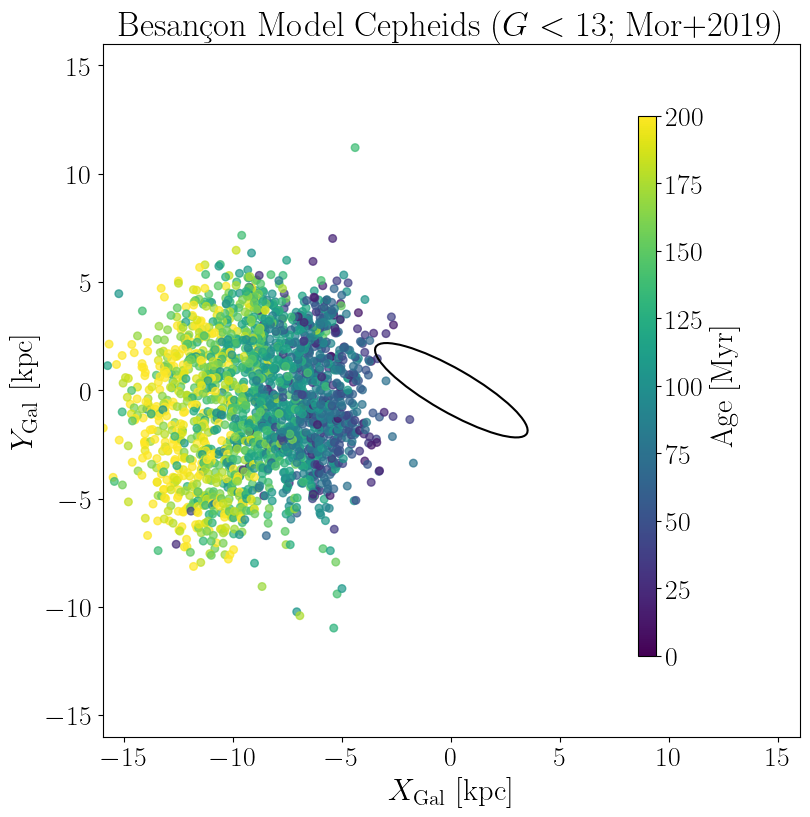

In [10]:
fig = plt.figure(figsize=(9.0, 9.0))
ax  = plt.subplot(111)

plot_kde=False
xrange=(-16,16)
yrange=(-16,16)
grid=400

vmin = 0
vmax = 200
cmap = "viridis"
ec   = None

# PLOT  
plt.scatter(bgm2019["xgal"][cut], bgm2019["ygal"][cut], s=30, c=1000.*bgm2019["Age"][cut], marker="o",
            edgecolor=ec, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.7) 
#plt.scatter(bgm2018_cut["xgal"], bgm2018_cut["ygal"], s=30, c=1000.*bgm2018_cut["Age"], marker="o",
#            edgecolor=ec, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.7) 
# Beautify  the plot
plt.axis([xrange[0], xrange[1], yrange[0], yrange[1]])

ax.set_xlabel(r"$X_{\rm Gal}$  [kpc]", fontsize=22)
ax.set_ylabel(r"$Y_{\rm Gal}$    [kpc]", fontsize=22)
#ax.legend(loc="upper left", fontsize=15)
e1 = patches.Ellipse((0, 0.), 8., 2.,
                     angle=-30., linewidth=1.5, fill=False, zorder=1)
ax.add_patch(e1)
plt.title(r"Besançon Model Cepheids ($G<13$; Mor+2019)", fontsize=25)

cax = fig.add_axes([0.72, 0.2, 0.02, 0.6]) # meaning: ([left, bottom, width, height])
norm = matplotlib.colors.Normalize(vmin=0., vmax=vmax)

cb = matplotlib.colorbar.ColorbarBase(cax, norm=norm, cmap="viridis") #, cmap="inferno", norm=norm, spacing='proportional'
cb.set_label('Age [Myr]', fontsize=22)
plt.show()
#plt.savefig("./im/XYmap_bgm2018.png", dpi=200)

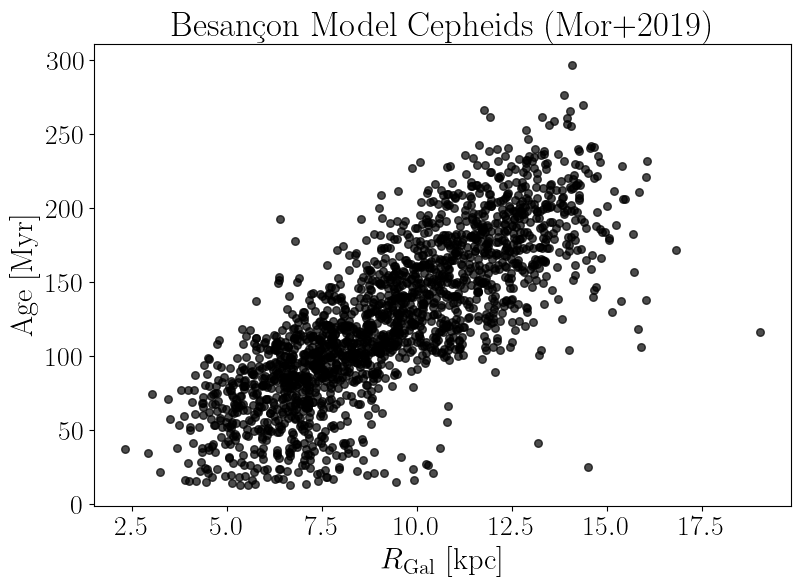

In [11]:
fig = plt.figure(figsize=(9.0, 6.0))
ax  = plt.subplot(111)
# PLOT  
plt.scatter(np.sqrt(bgm2019["xgal"][cut]**2. + bgm2019["ygal"][cut]**2.), 1000.*bgm2019["Age"][cut],
            s=30, c="k", marker="o",
            edgecolor=ec, alpha=0.7) 
# Beautify  the plot
#plt.axis([xrange[0], xrange[1], yrange[0], yrange[1]])

ax.set_xlabel(r"$R_{\rm Gal}$  [kpc]", fontsize=22)
ax.set_ylabel(r"Age    [Myr]", fontsize=22)
plt.title("Besançon Model Cepheids (Mor+2019)", fontsize=25)

plt.show()
#plt.savefig("./im/R_age_bgm2018.png", dpi=200)

In [12]:
list(bgm2019.dtype.names)

['G',
 'B-V',
 'V-I',
 'G-V',
 'mux',
 'muy',
 'Vr',
 'UU',
 'VV',
 'WW',
 'Mv',
 'CL',
 'Typ',
 'Teff',
 'logg',
 'PopBin',
 'Age',
 'Mass',
 'Mbol',
 'Radius',
 '[Fe/H]',
 'longitude',
 'latitude',
 'RA2000.0',
 'DEC2000.0',
 'Dist',
 'xgal',
 'ygal',
 'zgal',
 'Av',
 '[alpha/Fe]',
 'track',
 'bin',
 'sep[AU]',
 'VCA',
 'BVt',
 'Vt']

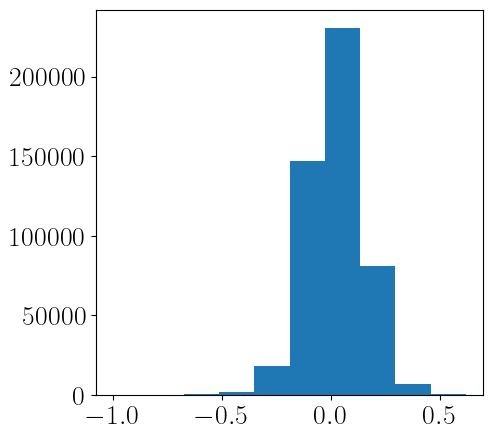

In [13]:
fig = plt.figure(figsize=(5, 5))
ax  = plt.subplot(111)
plt.hist(bgm2019["[Fe/H]"])
plt.show()

### Looking at the CMD & the age-metallicity relation

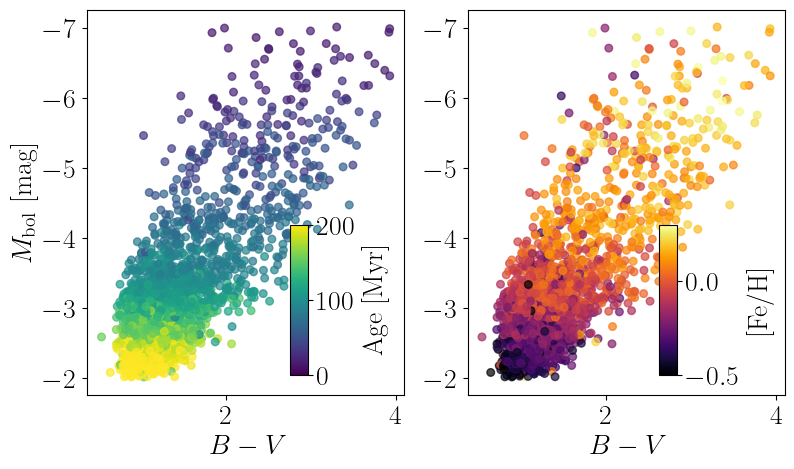

In [14]:
fig = plt.figure(figsize=(9.0, 5))
ax  = plt.subplot(121)
# PLOT  
plt.scatter(bgm2019["B-V"][cut], bgm2019["Mbol"][cut], s=30, c=1000.*bgm2019["Age"][cut], marker="o",
            edgecolor=ec, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.7) 
# Beautify  the plot
#plt.axis([xrange[0], xrange[1], yrange[0], yrange[1]])
cax = fig.add_axes([0.35, 0.15, 0.02, 0.3]) # meaning: ([left, bottom, width, height])
norm = matplotlib.colors.Normalize(vmin=0., vmax=vmax)
cb = matplotlib.colorbar.ColorbarBase(cax, norm=norm, cmap="viridis") #, cmap="inferno", norm=norm, spacing='proportional'
cb.set_label('Age [Myr]', fontsize=20)

ax.set_xlabel(r"$B-V$", fontsize=20)
ax.set_ylabel(r"$M_{\rm bol}$ [mag]", fontsize=20)
#ax.legend(loc="upper left", fontsize=15)
ax.invert_yaxis()

ax  = plt.subplot(122)
# PLOT  
plt.scatter(bgm2019["B-V"][cut], bgm2019["Mbol"][cut], s=30, c=bgm2019["[Fe/H]"][cut], marker="o",
            edgecolor=ec, cmap="inferno", alpha=0.7, vmin=-.5, vmax=.3) 
cax2 = fig.add_axes([0.76, 0.15, 0.02, 0.3]) # meaning: ([left, bottom, width, height])
norm2 = matplotlib.colors.Normalize(vmin=-.5, vmax=.3)
cb2 = matplotlib.colorbar.ColorbarBase(cax2, norm=norm2, cmap="inferno") #, cmap="inferno", norm=norm, spacing='proportional'
cb2.set_label('[Fe/H]', fontsize=20)
ax.set_xlabel(r"$B-V$", fontsize=20)
ax.invert_yaxis()

plt.show()
#plt.savefig("./im/CMD_bgm2018.png", dpi=200)

/tmp/ipykernel_420168/1862208536.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  plt.scatter(bgm2019["[Fe/H]"][cut], 1000.*bgm2019["Age"][cut], s=30, marker="o",


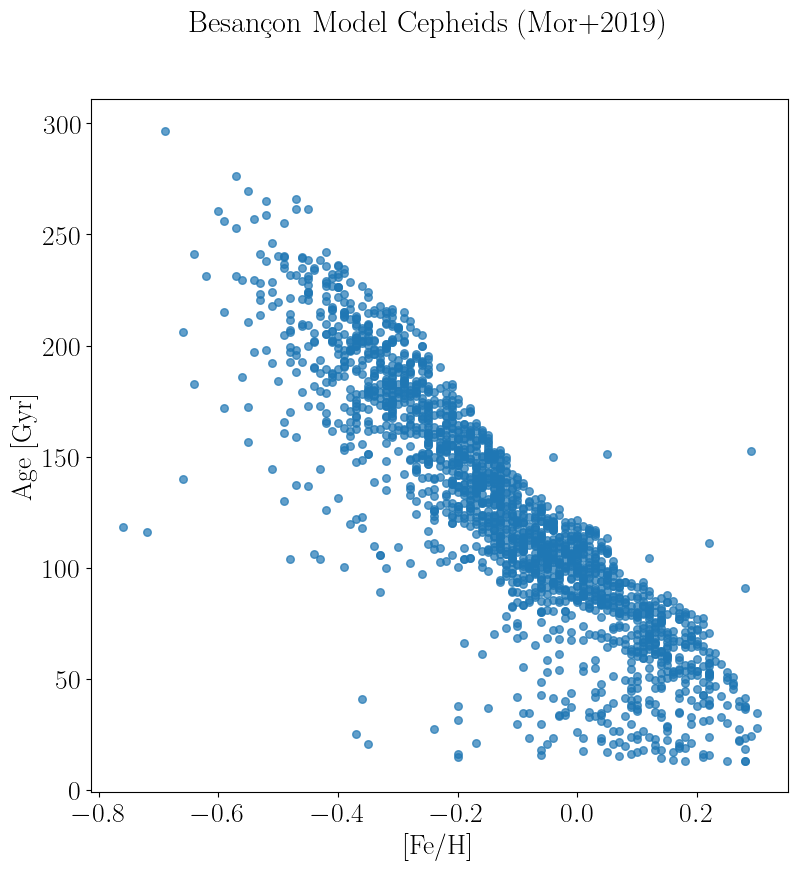

In [15]:
fig = plt.figure(figsize=(9.0, 9))
ax  = plt.subplot(111)
# PLOT  
plt.scatter(bgm2019["[Fe/H]"][cut], 1000.*bgm2019["Age"][cut], s=30, marker="o",
            edgecolor=ec, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.7) 
# Beautify  the plot
#plt.axis([xrange[0], xrange[1], yrange[0], yrange[1]])
norm = matplotlib.colors.Normalize(vmin=0., vmax=vmax)
ax.set_xlabel(r"[Fe/H]", fontsize=20)
ax.set_ylabel(r"Age [Gyr]", fontsize=20)

plt.suptitle("Besançon Model Cepheids (Mor+2019)", fontsize=22)

plt.show()
#plt.savefig("./im/agemet_bgm2018.png", dpi=200)

## Combine the plots of Besançon model and the data:

/tmp/ipykernel_420168/899161331.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


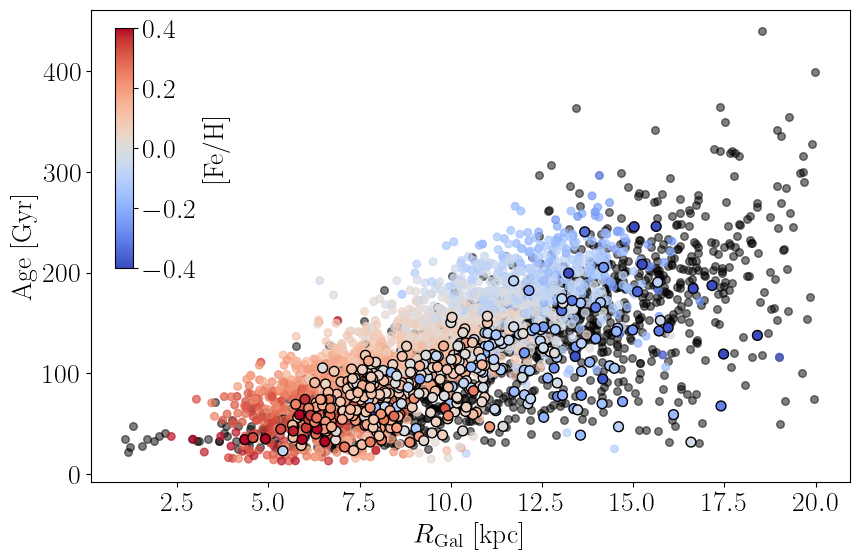

In [22]:
fig = plt.figure(figsize=(9, 6))
ax  = plt.subplot(111)
disc = (pietru["R"] < 20)
plt.scatter(pietru["R"][disc], pietru["ageMyr"][disc],s=30, c='k', marker="o", alpha=0.5)

### plot points from Besançon simu
plt.scatter(np.sqrt(bgm2019["xgal"][cut]**2. + bgm2019["ygal"][cut]**2.), 1000.*bgm2019["Age"][cut],
            s=30, c=bgm2019["[Fe/H]"][cut], marker="o",
            edgecolor=ec, alpha=0.7, cmap="coolwarm") 

# Overplot Cepheids with known metallicities in colour
spec = np.isfinite(pietru["__Fe_H_"])
plt.scatter(pietru["R"][disc & spec], 
            pietru["ageMyr"][disc & spec],
            s=50, c=pietru["__Fe_H_"][disc & spec], 
            marker="o", edgecolor="k", vmin=-.4, vmax=0.4, cmap="coolwarm")



ax.set_xlabel(r"$R_{\rm Gal}$    [kpc]", fontsize=20)
ax.set_ylabel(r"Age [Gyr]", fontsize=20)

cax = fig.add_axes([0.15, 0.52, 0.02, 0.4])
norm = matplotlib.colors.Normalize(vmin=-0.4, vmax=0.4)
cb = matplotlib.colorbar.ColorbarBase(cax, norm=norm, cmap="coolwarm") #, cmap="inferno", norm=norm, spacing='proportional'
cb.set_label('[Fe/H]')
#cb.set_label('Period [days]')
plt.tight_layout()
#plt.savefig("./im/R_age_pietru.png")
plt.show()

/tmp/ipykernel_420168/2029081347.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


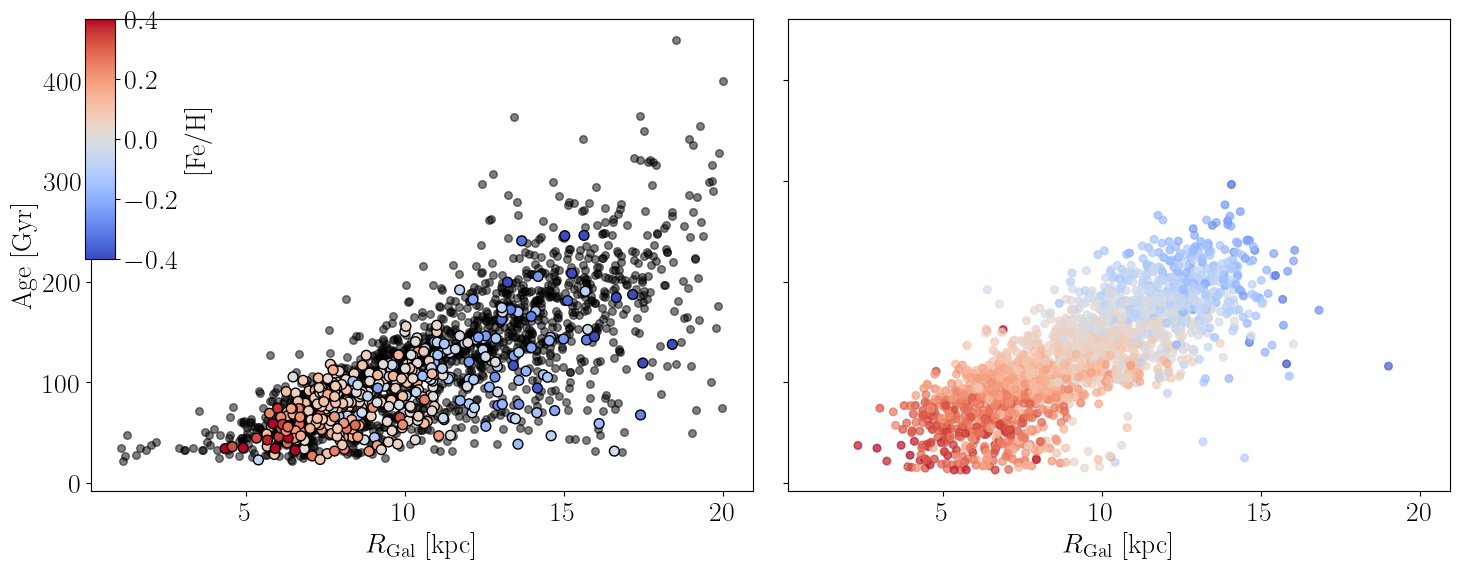

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)
#ax  = plt.subplot(111)
ax1.scatter(np.sqrt(pietru["X"][disc]**2. + pietru["Y"][disc]**2.), pietru["ageMyr"][disc],
            s=30, c='k', marker="o", alpha=0.5)

### plot points from Besançon simu
ax2.scatter(np.sqrt(bgm2019["xgal"][cut]**2. + bgm2019["ygal"][cut]**2.), 1000.*bgm2019["Age"][cut],
            s=30, c=bgm2019["[Fe/H]"][cut], marker="o",
            edgecolor=ec, alpha=0.7, cmap="coolwarm") 

# Overplot Cepheids with known metallicities in colour
spec = np.isfinite(pietru["__Fe_H_"])
ax1.scatter(np.sqrt(pietru["X"][disc & spec]**2. + pietru["Y"][disc & spec]**2.), 
            pietru["ageMyr"][disc & spec],
            s=50, c=pietru["__Fe_H_"][disc & spec], marker="o", edgecolor="k", vmin=-.4, vmax=0.4, cmap="coolwarm")



ax1.set_xlabel(r"$R_{\rm Gal}$    [kpc]", fontsize=20)
ax1.set_ylabel(r"Age [Gyr]", fontsize=20)
ax2.set_xlabel(r"$R_{\rm Gal}$    [kpc]", fontsize=20)
#ax2.set_ylabel(r"Age [Gyr]", fontsize=20)

cax = fig.add_axes([0.07, 0.55, 0.02, 0.4])
norm = matplotlib.colors.Normalize(vmin=-0.4, vmax=0.4)
cb = matplotlib.colorbar.ColorbarBase(cax, norm=norm, cmap="coolwarm") #, cmap="inferno", norm=norm, spacing='proportional'
cb.set_label('[Fe/H]')
#cb.set_label('Period [days]')
plt.tight_layout()
#plt.savefig("./im/R_age_pietru.png")
plt.show()

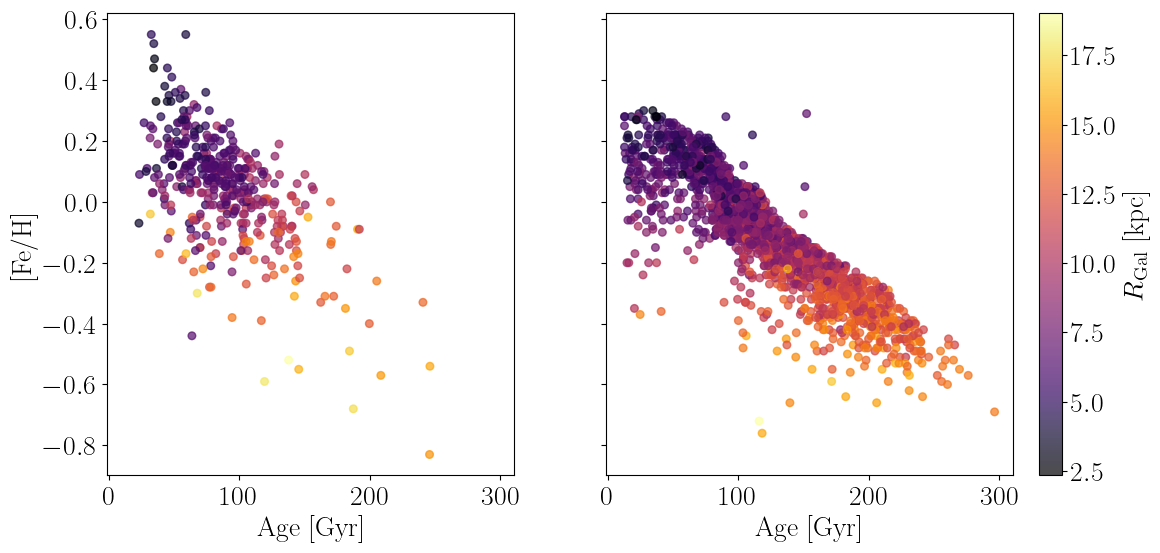

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6), sharex=True, sharey=True, gridspec_kw={'width_ratios': [0.8, 1]})

c1 = ax1.scatter(pietru["ageMyr"][disc & spec], pietru["__Fe_H_"][disc & spec],
            s=30, c=np.sqrt(pietru["X"][disc & spec]**2. + pietru["Y"][disc & spec]**2.), 
             marker="o", edgecolor=ec, alpha=0.7, cmap="inferno")

c2 = ax2.scatter(1000.*bgm2019["Age"][cut], bgm2019["[Fe/H]"][cut],
            s=30, c=np.sqrt(bgm2019["xgal"][cut]**2. + bgm2019["ygal"][cut]**2.), marker="o",
            edgecolor=ec, alpha=0.7, cmap="inferno")
ax1.set_ylabel("[Fe/H]", fontsize=20)
ax1.set_xlabel(r"Age [Gyr]", fontsize=20)
ax2.set_xlabel(r"Age [Gyr]", fontsize=20)

#cax = fig.add_axes([0.15, 0.45, 0.02, 0.4])
#norm = matplotlib.colors.Normalize(vmin=0, vmax=20)
#cb = matplotlib.colorbar.ColorbarBase(cax, norm=norm, cmap="inferno") #, cmap="coolwarm", norm=norm, spacing='proportional'
cb = fig.colorbar(c2, ax=ax2)
cb.set_label(r"$R_{\rm Gal}$ [kpc]")

plt.show()

/tmp/ipykernel_420168/1222733132.py:67: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax4.scatter(bgm2019["[Fe/H]"], 1000.*bgm2019["Age"], s=30, marker="o",
/tmp/ipykernel_420168/1222733132.py:69: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  c4 = ax4.scatter(bgm2019["[Fe/H]"][cut], 1000.*bgm2019["Age"][cut], s=30, marker="o",
/tmp/ipykernel_420168/1222733132.py:142: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("./im/cepheids_bgm2019.png", format='png', bbox_inches='tight')
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


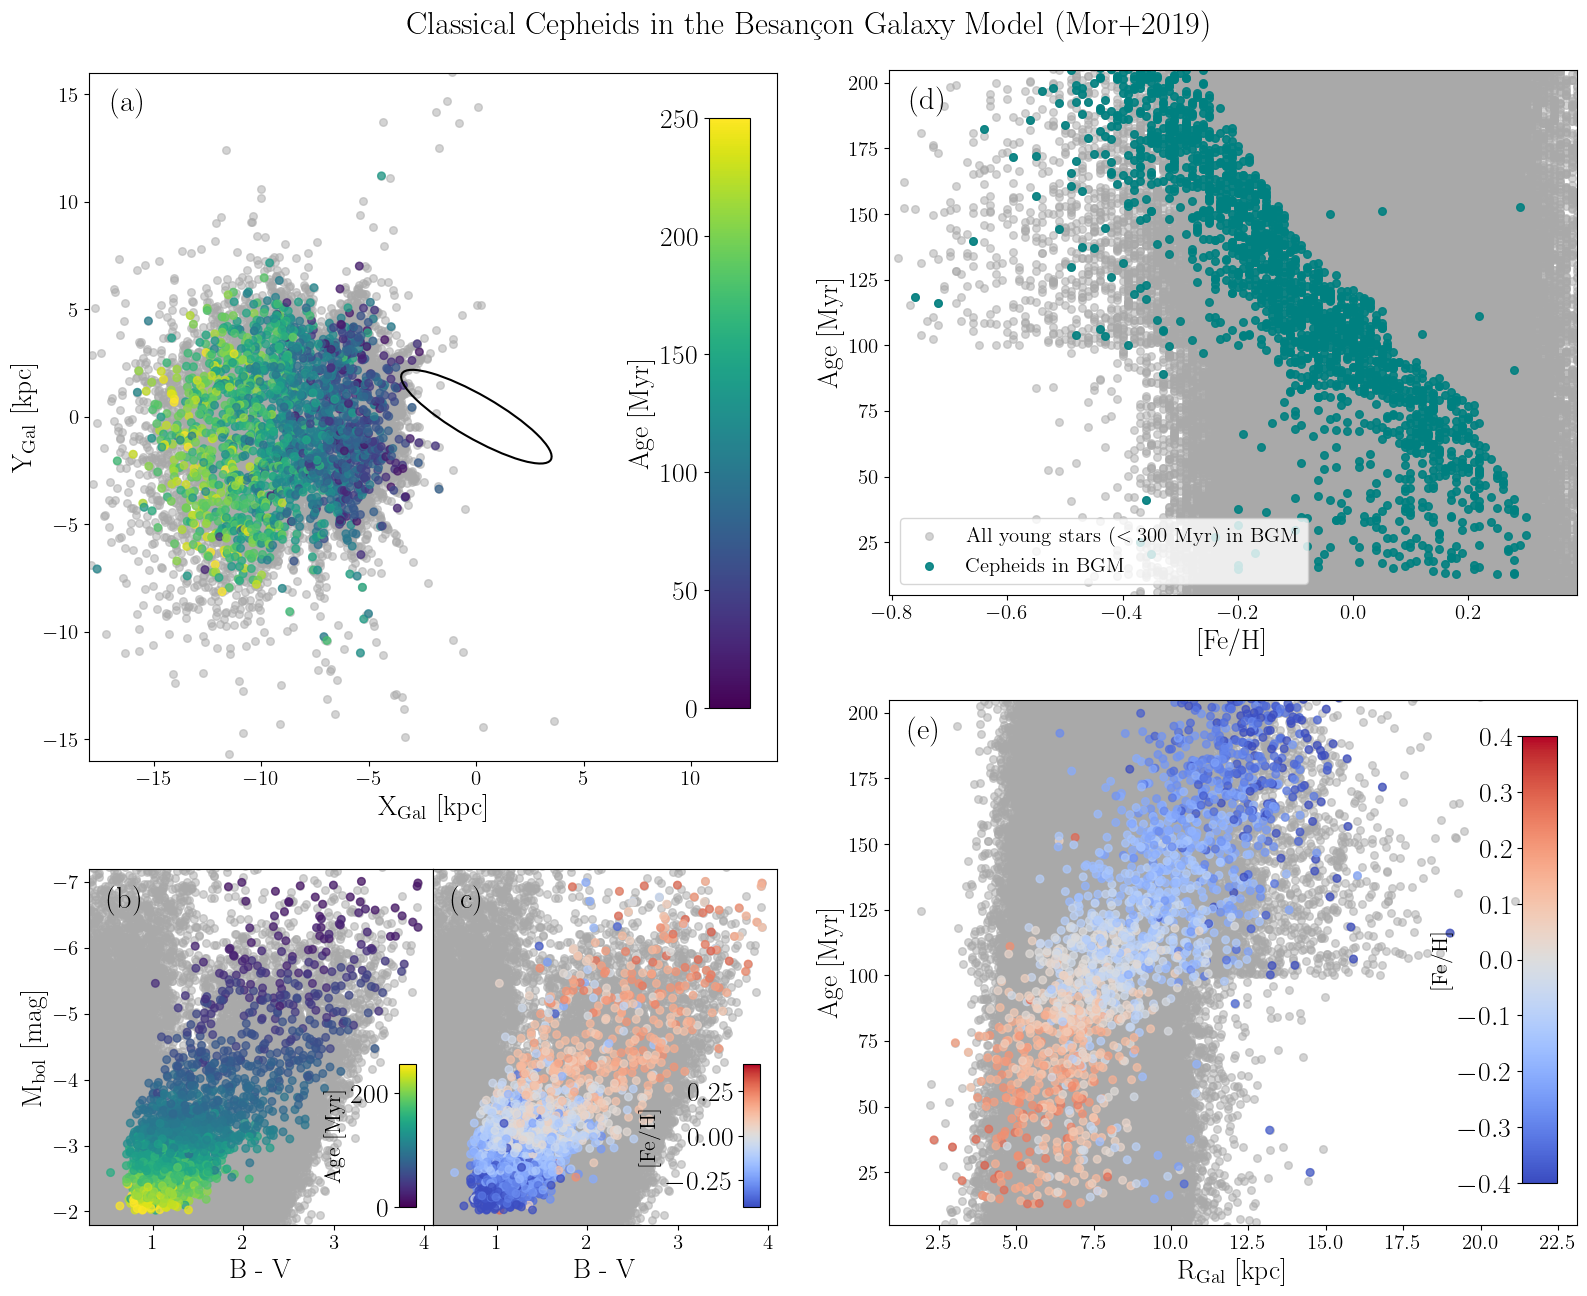

In [30]:
fs = 20

fig = plt.figure(figsize=(16, 15)) #constrained_layout=False)
########################################################
#################### STRUCTURE
gs1 = fig.add_gridspec(nrows=2, ncols=2, left=0.05, right=0.48,
                        wspace=0.0, height_ratios=[3.9,2])
ax1 = fig.add_subplot(gs1[0, :])
ax2 = fig.add_subplot(gs1[1, 0])
ax3 = fig.add_subplot(gs1[1, 1], sharex=ax2)#, sharey=ax2)

gs2 = fig.add_gridspec(nrows=2, ncols=1, left=0.55, right=0.98,
                        hspace=0.2)
ax4 = fig.add_subplot(gs2[0, 0])
ax5 = fig.add_subplot(gs2[1, 0], sharey=ax4)

########################################################
#################### PLOT DATA
##### plot positions in X-Y

vmax=250
ax1.scatter(bgm2019["xgal"], bgm2019["ygal"], s=30, marker="o",
            edgecolor=ec, c="darkgrey", alpha=0.5)
c1 = ax1.scatter(bgm2019["xgal"][cut], bgm2019["ygal"][cut], s=30, c=1000.*bgm2019["Age"][cut], marker="o",
            edgecolor=ec, cmap="viridis", vmin=vmin, vmax=vmax, alpha=0.7)
e1 = patches.Ellipse((0, 0.), 8., 2.,
                     angle=-30., linewidth=1.5, fill=False, zorder=1)
ax1.add_patch(e1)
### cbar
x1 = ax1.get_position().xmax - ax1.get_position().xmin
y1 = ax1.get_position().ymax - ax1.get_position().ymin
cax1 = fig.add_axes([ax1.get_position().xmax-0.1*x1, ax1.get_position().ymin+0.08*y1, 0.06*x1, 0.85*y1]) # meaning: ([left, bottom, width, height])
#cax1 = fig.add_axes(np.array([0.42, 0.5, 0.02, 0.35]))
norm1 = matplotlib.colors.Normalize(vmin=0., vmax=vmax)
cb1 = matplotlib.colorbar.ColorbarBase(cax1, norm=norm1, cmap="viridis") #, cmap="inferno", norm=norm, spacing='proportional'
cb1.set_label('Age [Myr]', fontsize=fs)


##### PLOT Mbol vs B-V, age colored  
ax2.scatter(bgm2019["B-V"], bgm2019["Mbol"], s=30, c='darkgrey', marker="o",
            edgecolor=ec, alpha=0.5)
c2 = ax2.scatter(bgm2019["B-V"][cut], bgm2019["Mbol"][cut], s=30, c=1000.*bgm2019["Age"][cut], marker="o",
            edgecolor=ec, cmap="viridis", vmin=vmin, vmax=vmax, alpha=0.7)
### Plot Mbol vs B-V, Fe/H colored
ax3.scatter(bgm2019["B-V"], bgm2019["Mbol"], s=30, c='darkgrey', marker="o",
            edgecolor=ec, alpha=0.5)
c3 = ax3.scatter(bgm2019["B-V"][cut], bgm2019["Mbol"][cut], s=30, c=bgm2019["[Fe/H]"][cut], marker="o",
            edgecolor=ec, cmap="coolwarm", alpha=0.7, vmin=-.4, vmax=.4)
### cbars
x2 = ax2.get_position().xmax - ax2.get_position().xmin
y2 = ax2.get_position().ymax - ax2.get_position().ymin
x3 = ax3.get_position().xmax - ax3.get_position().xmin
y3 = ax3.get_position().ymax - ax3.get_position().ymin
# age
cax2 = fig.add_axes([ax2.get_position().xmax-0.1*x2, ax2.get_position().ymin+0.05*y2, 0.05*x2, 0.4*y2]) # meaning: ([left, bottom, width, height])
norm2 = matplotlib.colors.Normalize(vmin=0., vmax=vmax)
cb2 = matplotlib.colorbar.ColorbarBase(cax2, norm=norm2, cmap="viridis") #, cmap="inferno", norm=norm, spacing='proportional'
cb2.set_label('Age [Myr]', fontsize=fs-4)
## Fe/H
cax3 = fig.add_axes([ax3.get_position().xmax-0.1*x3, ax3.get_position().ymin+0.05*y3, 0.05*x3, 0.4*y3]) # meaning: ([left, bottom, width, height])
norm3 = matplotlib.colors.Normalize(vmin=-.4, vmax=0.4)
cb3 = matplotlib.colorbar.ColorbarBase(cax3, norm=norm3, cmap="coolwarm") #, cmap="inferno", norm=norm, spacing='proportional'
cb3.set_label('[Fe/H]', fontsize=fs-4)


##### plot age-Fe/H relation
ax4.scatter(bgm2019["[Fe/H]"], 1000.*bgm2019["Age"], s=30, marker="o",
            edgecolor=ec, c='darkgrey', vmin=vmin, vmax=vmax, alpha=0.5, label=r'All young stars ($< 300$ Myr) in BGM') 
c4 = ax4.scatter(bgm2019["[Fe/H]"][cut], 1000.*bgm2019["Age"][cut], s=30, marker="o",
            edgecolor=ec, c='teal', vmin=vmin, vmax=vmax, alpha=0.9, label='Cepheids in BGM')

x4 = ax4.get_position().xmax - ax4.get_position().xmin
y4 = ax4.get_position().ymax - ax4.get_position().ymin
##### plot Rgal-Fe/H relation
ax5.scatter(np.sqrt(bgm2019["xgal"]**2. + bgm2019["ygal"]**2.), 1000.*bgm2019["Age"],
            s=30, c="darkgrey", marker="o",
            edgecolor=ec, alpha=0.5) 
c5 = ax5.scatter(np.sqrt(bgm2019["xgal"][cut]**2. + bgm2019["ygal"][cut]**2.), 1000.*bgm2019["Age"][cut],
            s=30, marker="o", c=bgm2019['[Fe/H]'][cut], #c='teal',
            cmap='coolwarm', vmin=-.4, vmax=0.4,
            edgecolor=ec, alpha=0.7)
### cbar
x5 = ax5.get_position().xmax - ax5.get_position().xmin
y5 = ax5.get_position().ymax - ax5.get_position().ymin
cax5 = fig.add_axes([ax5.get_position().xmax-0.08*x5, ax5.get_position().ymin+0.08*y5, 0.05*x5, 0.85*y5]) # meaning: ([left, bottom, width, height])
norm5 = matplotlib.colors.Normalize(vmin=-.4, vmax=0.4)
cb5 = matplotlib.colorbar.ColorbarBase(cax5, norm=norm5, cmap="coolwarm") #, cmap="inferno", norm=norm, spacing='proportional'
cb5.set_label('[Fe/H]', fontsize=fs-4)

########################################################
#################### AXIS business

#ax1.axis([-16, 16, -16, 16])
ax1.set_xlim(-18, 14)
ax1.set_ylim(-16, 16)
ax1.set_aspect('equal', 'box')
ax1.set_xlabel(r"X$_{\rm Gal}$ [kpc]", fontsize=fs)
ax1.set_ylabel(r"Y$_{\rm Gal}$ [kpc]", fontsize=fs)
cax1.yaxis.set_ticks_position('left')
cax1.yaxis.set_label_position('left')
ax1.tick_params(axis='both', which='major', labelsize=15)

ax2.set_xlabel("B - V", fontsize=fs)
ax3.set_xlabel("B - V", fontsize=fs)
ax2.set_ylabel(r"M$_{\rm bol}$ [mag]", fontsize=fs)
ax2.set_xlim((0.3, 4.1))
ax2.set_ylim((-7.2, -1.8))
ax3.set_ylim((-7.2, -1.8))
ax2.invert_yaxis()
ax3.invert_yaxis()
ax3.set_yticks([])
cax2.yaxis.set_ticks_position('left')
cax2.yaxis.set_label_position('left')
cax3.yaxis.set_ticks_position('left')
cax3.yaxis.set_label_position('left')
ax2.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='major', labelsize=15)

ax4.set_xlabel(r"[Fe/H]", fontsize=fs)
ax4.set_ylabel(r"Age [Myr]", fontsize=fs)
ax4.set_ylim((5, 205))
ax4.set_xlim((-0.805, 0.39))
ax4.tick_params(axis='both', which='major', labelsize=15)
ax4.legend(fontsize=15)

ax5.set_xlabel(r"R$_{\rm Gal}$  [kpc]", fontsize=fs)
ax5.set_ylabel(r"Age [Myr]", fontsize=fs)
ax5.tick_params(axis='both', which='major', labelsize=15)
cax5.yaxis.set_ticks_position('left')
cax5.yaxis.set_label_position('left')

###########################################################
#################### title and subnames
ax1.text(x=-17, y=14.2, s='(a)', fontsize=fs+2)
ax2.text(x=0.5, y=-6.6, s='(b)', fontsize=fs+2)
ax3.text(x=0.5, y=-6.6, s='(c)', fontsize=fs+2)
ax4.text(x=-0.77, y=190, s='(d)', fontsize=fs+2)
ax5.text(x=1.5, y=190, s='(e)', fontsize=fs+2)

fig.suptitle("Classical Cepheids in the Besançon Galaxy Model (Mor+2019)", fontsize=fs+3, y=0.92)

plt.savefig("./im/cepheids_bgm2019.png", format='png', bbox_inches='tight')
plt.show()